In [ ]:
!rm -f -R /content/dataset

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16117912560687018548
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14626652160
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6008776670397541165
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [ ]:
import urllib.request
import os
import zipfile

def download_from_url(file_url):
  filename = file_url.split('/')[-1]
  destination_path = os.path.join("/content", "dataset", filename)

  if not os.path.exists(destination_path):
    urllib.request.urlretrieve(file_url, destination_path)
    unzipped_destination_path = destination_path.replace(".zip", "")

    with zipfile.ZipFile(destination_path, 'r') as zip_ref:
        zip_ref.extractall(unzipped_destination_path)
        os.remove(destination_path)

In [ ]:
os.mkdir("/content/dataset")
download_from_url("https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip")

In [ ]:
import numpy as np
import random
import os
import cv2 as cv
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential, load_model
from keras.layers import Conv2D, Dense, Flatten, Rescaling, AveragePooling2D, Dropout

In [ ]:
def load_training_images(current_path):
  images = []
  labels = []

  classes = 43

  for i in range(classes):
      path = os.path.join(current_path, str(str(i).zfill(5)))
      img_folder = os.listdir(path)
      for j in img_folder:
          try:
              image = cv.imread(str(path+'/'+j))
              image = cv.resize(image, (32, 32))
              image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
              image = np.array(image)
              images.append(image)
              label = np.zeros(classes)
              label[i] = 1.0
              labels.append(label)
          except Exception as e:
              pass

  images = np.array(images)
  images = images/255
  labels = np.array(labels)

  print('Images shape:', images.shape)
  print('Labels shape:', labels.shape)

  return images, labels

In [ ]:
images, labels = load_training_images('/content/dataset/GTSRB_Final_Training_Images/GTSRB/Final_Training/Images')
images = images.astype(np.float32)
labels = labels.astype(np.float32)

Images shape: (39209, 32, 32)
Labels shape: (39209, 43)


In [ ]:
training_images, test_images, training_labels, test_labels = train_test_split(images, labels, test_size=0.2, shuffle=True)

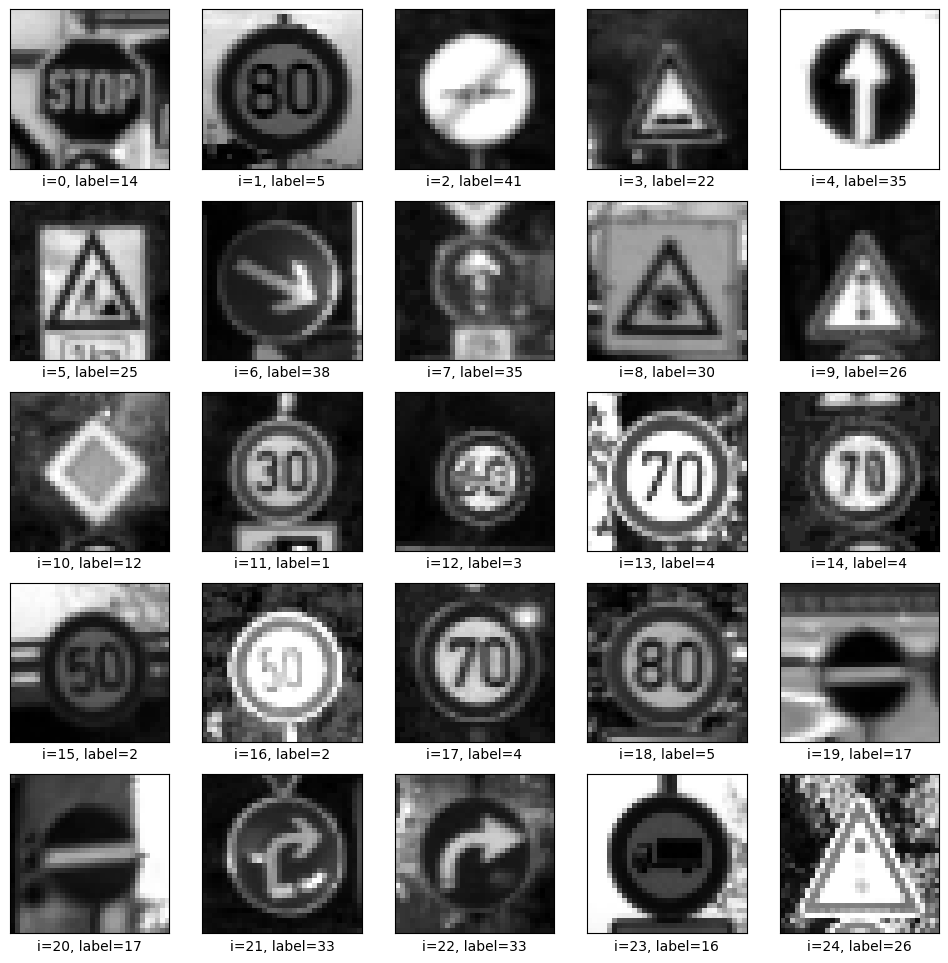

In [ ]:
plt.figure(figsize=(12, 12))
start_index = 0
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    label = np.argmax(training_labels[start_index+i])

    plt.xlabel('i={}, label={}'.format(start_index+i, label))
    plt.imshow(training_images[start_index+i], cmap='gray')
plt.show()

# **Prima arhitectura a modelului**

In [ ]:
model = Sequential([
    Rescaling(1, input_shape=(32, 32, 1)),
    AveragePooling2D(pool_size=(4, 4)),
    Conv2D(filters=6, kernel_size=(5, 5), activation='relu'),
    AveragePooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(units=30, activation='relu'),
    Dense(units=43, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 32, 32, 1)         0         
                                                                 
 average_pooling2d (Average  (None, 8, 8, 1)           0         
 Pooling2D)                                                      
                                                                 
 conv2d (Conv2D)             (None, 4, 4, 6)           156       
                                                                 
 average_pooling2d_1 (Avera  (None, 2, 2, 6)           0         
 gePooling2D)                                                    
                                                                 
 flatten (Flatten)           (None, 24)                0         
                                                                 
 dense (Dense)               (None, 30)                7

In [ ]:
import tensorflow as tf

with tf.device('/device:GPU:0'):
  history = model.fit(training_images, training_labels, epochs=50,
                      validation_data=(test_images, test_labels))

Epoch 1/50
981/981 [==============================] - 7s 4ms/step - loss: 3.3951 - accuracy: 0.0960 - val_loss: 3.2000 - val_accuracy: 0.1438
Epoch 2/50
981/981 [==============================] - 4s 4ms/step - loss: 3.0565 - accuracy: 0.1685 - val_loss: 2.9049 - val_accuracy: 0.1931
Epoch 3/50
981/981 [==============================] - 4s 4ms/step - loss: 2.7840 - accuracy: 0.2343 - val_loss: 2.6380 - val_accuracy: 0.2793
Epoch 4/50
981/981 [==============================] - 4s 4ms/step - loss: 2.5261 - accuracy: 0.2993 - val_loss: 2.3917 - val_accuracy: 0.3254
Epoch 5/50
981/981 [==============================] - 4s 5ms/step - loss: 2.3059 - accuracy: 0.3531 - val_loss: 2.1944 - val_accuracy: 0.3838
Epoch 6/50
981/981 [==============================] - 4s 4ms/step - loss: 2.1252 - accuracy: 0.4052 - val_loss: 2.0233 - val_accuracy: 0.4260
Epoch 7/50
981/981 [==============================] - 4s 4ms/step - loss: 1.9846 - accuracy: 0.4436 - val_loss: 1.9116 - val_accuracy: 0.4663
Epoch 

In [ ]:
val_loss, val_acc = model.evaluate(training_images, training_labels, verbose=2)
print('\nValidation accuracy:', val_acc)
print('\nValidation loss:', val_loss)

981/981 - 2s - loss: 1.0618 - accuracy: 0.6846 - 2s/epoch - 2ms/step

Validation accuracy: 0.6846367120742798

Validation loss: 1.0618157386779785


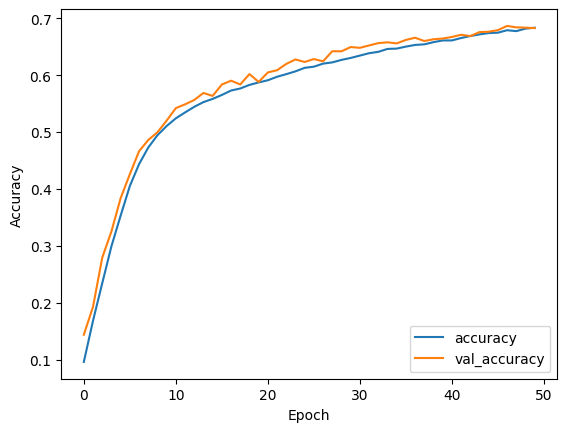

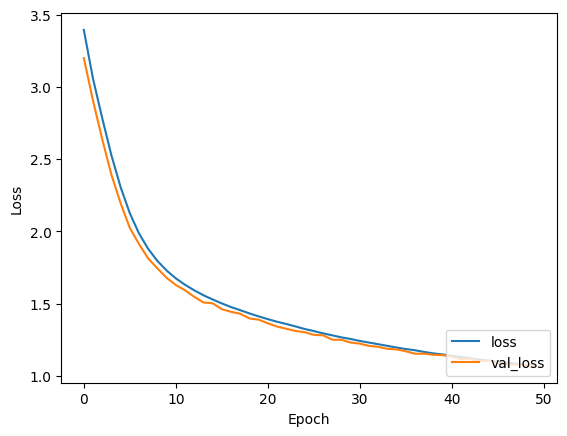

In [ ]:
plt.figure(0)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.figure(1)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

In [ ]:
os.mkdir("/content/first")
model.save('/content/first/first_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# **Arhitectura finala a modelului**



In [ ]:
model = Sequential([
    Rescaling(1, input_shape=(32, 32, 1)),
    Conv2D(filters=6, kernel_size=(5, 5), activation='relu'),
    AveragePooling2D(pool_size=(2, 2)),
    Conv2D(filters=16, kernel_size=(5, 5), activation='relu'),
    AveragePooling2D(pool_size=(2, 2)),
    Conv2D(filters=120, kernel_size=(5, 5), activation='relu'),
    Dropout(0.2),
    Flatten(),
    Dense(units=120, activation='relu'),
    Dense(units=43, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 32, 32, 1)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d_2 (Avera  (None, 14, 14, 6)         0         
 gePooling2D)                                                    
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_3 (Avera  (None, 5, 5, 16)          0         
 gePooling2D)                                                    
                                                                 
 conv2d_3 (Conv2D)           (None, 1, 1, 120)        

In [ ]:
import tensorflow as tf

with tf.device('/device:GPU:0'):
  history = model.fit(training_images, training_labels, epochs=50,
                      validation_data=(test_images, test_labels))

Epoch 1/50
981/981 [==============================] - 9s 6ms/step - loss: 1.9720 - accuracy: 0.4460 - val_loss: 0.8010 - val_accuracy: 0.7621
Epoch 2/50
981/981 [==============================] - 5s 5ms/step - loss: 0.7687 - accuracy: 0.7663 - val_loss: 0.4749 - val_accuracy: 0.8738
Epoch 3/50
981/981 [==============================] - 5s 5ms/step - loss: 0.5387 - accuracy: 0.8349 - val_loss: 0.3488 - val_accuracy: 0.9041
Epoch 4/50
981/981 [==============================] - 5s 5ms/step - loss: 0.4233 - accuracy: 0.8701 - val_loss: 0.2564 - val_accuracy: 0.9309
Epoch 5/50
981/981 [==============================] - 5s 5ms/step - loss: 0.3514 - accuracy: 0.8930 - val_loss: 0.2085 - val_accuracy: 0.9452
Epoch 6/50
981/981 [==============================] - 5s 6ms/step - loss: 0.2949 - accuracy: 0.9100 - val_loss: 0.1744 - val_accuracy: 0.9529
Epoch 7/50
981/981 [==============================] - 5s 5ms/step - loss: 0.2564 - accuracy: 0.9210 - val_loss: 0.1563 - val_accuracy: 0.9582
Epoch 

In [ ]:
val_loss, val_acc = model.evaluate(training_images, training_labels, verbose=2)
print('\nValidation accuracy:', val_acc)
print('\nValidation loss:', val_loss)

981/981 - 2s - loss: 0.0038 - accuracy: 0.9989 - 2s/epoch - 2ms/step

Validation accuracy: 0.9989479184150696

Validation loss: 0.003761039115488529


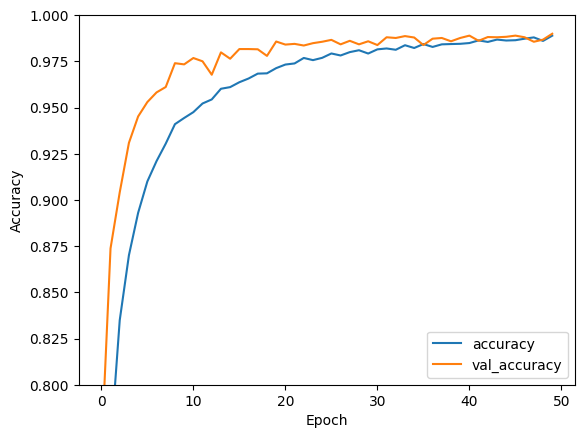

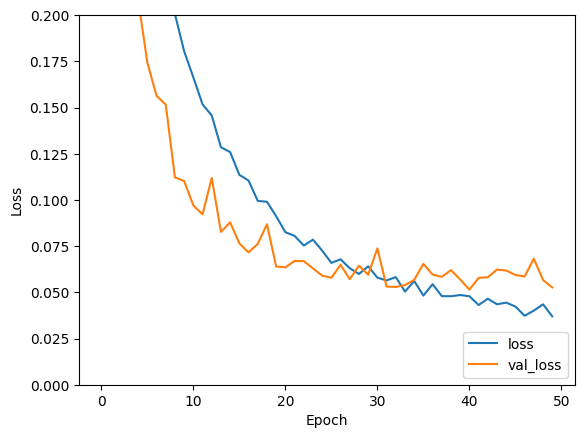

In [ ]:
plt.figure(0)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1])
plt.legend(loc='lower right')

plt.figure(1)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 0.2])
plt.legend(loc='lower right')

In [ ]:
os.mkdir("/content/final")
model.save('/content/final/final_model.h5')